In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle
from tqdm import tqdm

# machine learning
import xgboost as xgb

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer,  TfidfTransformer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier

# nlp
from spacy.en.language_data import STOP_WORDS
nlp = spacy.load('en')


from spooky import *

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

/home/wgilliam/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/wgilliam/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
PATH = 'data/spooky'

os.makedirs(f'{PATH}/models', exist_ok=True)
os.makedirs(f'{PATH}/tmp', exist_ok=True)

In [4]:
# get raw training and test datasets
train_df = pd.read_csv(f'{PATH}/train.csv')
test_df = pd.read_csv(f'{PATH}/test.csv')

print(f'Training size: {len(train_df)} | Test size: {len(test_df)}')
train_df.head()

Training size: 19579 | Test size: 8392


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


## Feature Engineering

Add representations of the text with stopwords removed (cleaned), lemmatized, and a lemmatized version with stopwords removed.

Also add columns, that for each document, represent the percentage of various parts of speech and/or the existence of various named entities.

In [5]:
def add_cols(df):
    rows = []
    for index, row in df.iterrows():
        cols = OrderedDict()
        
        # grab tokens, entities, and word tokens
        tokens = nlp(row['text'])
        ents = tokens.ents
        words = [ token for token in tokens if (not token.is_punct) ]
        
        # add different versions of text
        cols['cleaned_text'] = ' '.join([ t.text for t in tokens if (not t.is_stop) ])
        cols['lemmatized_text'] = ' '.join([ t.lemma_ for t in tokens ])
        cols['cleaned_lemmatized_text'] = ' '.join([ t.lemma_ for t in tokens if (not t.is_stop) ])
        
        # character and word counts
        cols['char_count'] = len(row['text'])
        cols['word_count'] = len(words)
        
        # ratio of token types to words
        cols['u_word_pct'] = len(set([ w.lemma_ for w in words ])) / len(words)
        cols['stopwords_pct'] = len([ w for w in words if (w.is_stop) ]) / len(words)
        cols['punctuation_pct'] = len([ t for t in tokens if (t.is_punct) ]) / len(tokens)
        cols['symbol_pct'] = len([ t for t in tokens if (t.pos_ == 'SYM') ]) / len(words)
        cols['number_pct'] = len([ t for t in tokens if (t.pos_ == 'NUM') ]) / len(words)
        cols['alpha_pct'] = len([ t for t in tokens if (t.is_alpha) ]) / len(words)
        
        cols['noun_pct'] = len([ t for t in tokens if (t.pos_ == 'NOUN') ]) / len(words)
        cols['verb_pct'] = len([ t for t in tokens if (t.pos_ == 'VERB') ]) / len(words)
        cols['adj_pct'] = len([ t for t in tokens if (t.pos_ == 'ADJ') ]) / len(words)
        cols['proper_name_pct'] = len([ t for t in tokens if (t.pos_ == 'PROPN') ]) / len(words)
    
        # ratio of named entity types
        cols['named_entity_pct'] = len(ents) / len(words)
        cols['named_entity_person_pct'] = len([ ent for ent in ents if (ent.label_ == 'PERSON') ]) / len(words)
        cols['named_entity_norp_pct'] = len([ ent for ent in ents if (ent.label_ == 'NORP') ]) / len(words)
        cols['named_entity_facility_pct'] = len([ ent for ent in ents if (ent.label_ == 'FACILITY') ]) / len(words)
        cols['named_entity_org_pct'] = len([ ent for ent in ents if (ent.label_ == 'ORG') ]) / len(words)
        cols['named_entity_gpe_pct'] = len([ ent for ent in ents if (ent.label_ == 'GPE') ]) / len(words)
        cols['named_entity_non_gpe_loc_pct'] = len([ ent for ent in ents if (ent.label_ == 'LOC') ]) / len(words)
        cols['named_entity_product_pct'] = len([ ent for ent in ents if (ent.label_ == 'PRODUCT') ]) / len(words)
        cols['named_entity_event_pct'] = len([ ent for ent in ents if (ent.label_ == 'EVENT') ]) / len(words)
        cols['named_entity_woa_pct'] = len([ ent for ent in ents if (ent.label_ == 'WORK_OF_ART') ]) / len(words)
        cols['named_entity_lang_pct'] = len([ ent for ent in ents if (ent.label_ == 'LANGUAGE') ]) / len(words)
        cols['named_entity_date_pct'] = len([ ent for ent in ents if (ent.label_ == 'DATE') ]) / len(words)
        cols['named_entity_time_pct'] = len([ ent for ent in ents if (ent.label_ == 'TIME') ]) / len(words)
        cols['named_entity_money_pct'] = len([ ent for ent in ents if (ent.label_ == 'MONEY') ]) / len(words)
        cols['named_entity_quantity_pct'] = len([ ent for ent in ents if (ent.label_ == 'QUANTITY') ]) / len(words)

        rows.append(cols)
        
    return pd.DataFrame(rows, columns=cols.keys())

In [6]:
train_df = pd.concat([train_df, add_cols(train_df)], axis=1)
test_df = pd.concat([test_df, add_cols(test_df)], axis=1)

Add probabilites and predictions learned from sentiment analysis with pre-trained language model

In [7]:
train_lm_results_df = pd.read_csv(f'{PATH}/20171207_2_train_preds.csv')
test_lm_results_df = pd.read_csv(f'{PATH}/20171207_2_test_preds.csv')

train_lm_results_df.drop(columns=['text', 'id', 'author'], axis=1, inplace=True)
test_lm_results_df.drop(columns=['text', 'id'], axis=1, inplace=True)

print(train_lm_results_df.shape, test_lm_results_df.shape)
train_lm_results_df.head()

(19579, 6) (8392, 6)


,EAP_probs,MWS_probs,HPL_probs,EAP_preds,MWS_preds,HPL_preds
0,0.963837,0.003548,0.032615,3.197491,-2.407068,-0.188668
1,0.431109,0.030999,0.537893,1.043664,-1.588753,1.264962
2,0.972993,0.016074,0.010933,3.097029,-1.006164,-1.391549
3,0.001067,0.989481,0.009452,-2.368515,4.463643,-0.187351
4,0.155847,0.046061,0.798092,0.258638,-0.960270,1.891985


In [8]:
train_df = pd.concat([train_df, train_lm_results_df], axis=1)
test_df = pd.concat([test_df, test_lm_results_df], axis=1)

train_df.head()

,id,text,author,cleaned_text,lemmatized_text,cleaned_lemmatized_text,char_count,word_count,u_word_pct,stopwords_pct,punctuation_pct,symbol_pct,number_pct,alpha_pct,noun_pct,verb_pct,adj_pct,proper_name_pct,named_entity_pct,named_entity_person_pct,named_entity_norp_pct,named_entity_facility_pct,named_entity_org_pct,named_entity_gpe_pct,named_entity_non_gpe_loc_pct,named_entity_product_pct,named_entity_event_pct,named_entity_woa_pct,named_entity_lang_pct,named_entity_date_pct,named_entity_time_pct,named_entity_money_pct,named_entity_quantity_pct,EAP_probs,MWS_probs,HPL_probs,EAP_preds,MWS_preds,HPL_preds
0,id26305,"This process, however, afforded me no means of...",EAP,"process , , afforded means ascertaining dimens...","this process , however , afford -PRON- no mean...","process , , afford means ascertain dimension d...",231,41,0.780488,0.634146,0.145833,0.0,0.000000,1.0,0.219512,0.195122,0.097561,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.963837,0.003548,0.032615,3.197491,-2.407068,-0.188668
1,id17569,It never once occurred to me that the fumbling...,HPL,occurred fumbling mere mistake .,-PRON- never once occur to -PRON- that the fum...,occur fumbling mere mistake .,71,14,0.928571,0.714286,0.066667,0.0,0.000000,1.0,0.142857,0.214286,0.071429,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.431109,0.030999,0.537893,1.043664,-1.588753,1.264962
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,"left hand gold snuff box , , capered hill , cu...","in -PRON- left hand be a gold snuff box , from...","left hand gold snuff box , , caper hill , cut ...",200,36,0.861111,0.472222,0.121951,0.0,0.000000,1.0,0.305556,0.111111,0.166667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.972993,0.016074,0.010933,3.097029,-1.006164,-1.391549
3,id27763,How lovely is spring As we looked from Windsor...,MWS,lovely spring looked Windsor Terrace sixteen f...,how lovely be spring as -PRON- look from winds...,lovely spring look windsor terrace sixteen fer...,206,34,0.911765,0.411765,0.105263,0.0,0.029412,1.0,0.205882,0.147059,0.176471,0.058824,0.058824,0.0,0.0,0.0,0.0,0.029412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001067,0.989481,0.009452,-2.368515,4.463643,-0.187351
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,"Finding , gold , Superintendent abandoned atte...","find nothing else , not even gold , the superi...","find , gold , superintendent abandon attempt ;...",174,27,0.888889,0.518519,0.129032,0.0,0.000000,1.0,0.222222,0.185185,0.148148,0.037037,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.155847,0.046061,0.798092,0.258638,-0.960270,1.891985


In [9]:
train_df.iloc[0].text

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

In [10]:
# train_df[train_df.named_entity_person_pct > 0.0]

In [11]:
# train_df['cleaned_text'] = train_df.text.apply(
#     lambda txt: ' '.join([ word.text for word in nlp(txt) if (not word.is_stop) ]))

# train_df['lemmatized_text'] = train_df.text.apply(
#     lambda txt: ' '.join([ word.lemma_ for word in nlp(txt) ]))

# train_df['cleaned_lemmatized_text'] = train_df.cleaned_text.apply(
#     lambda txt: ' '.join([ word.lemma_ for word in nlp(txt) ]))

In [12]:
# # counts
# def char_count(row):
#     return len(row['text'])

# def word_count(row):
#     tokens = [ token.text for token in nlp(row['text']) if (not token.is_punct) ]
#     return len(tokens)

# def u_word_pct(row):
#     tokens = [ token.lemma_ for token in nlp(row['text']) if (not token.is_punct) ]
#     return len(list(set(tokens))) / row['word_count']

# # ratio of token types
# def stopwords_pct(row):
#     tokens = [ token for token in nlp(row['text']) if (token.is_stop) ]
#     return len(tokens) / row['word_count']

# def punctuation_pct(row):
#     tokens = [ token for token in nlp(row['text']) if (token.is_punct) ]
#     return len(tokens) / row['word_count']

# def noun_pct(row):
#     tokens = [ token for token in nlp(row['text']) if (token.pos_ == 'NOUN') ]
#     return len(tokens) / row['word_count']

# def verb_pct(row):
#     tokens = [ token for token in nlp(row['text']) if (token.pos_ == 'VERB') ]
#     return len(tokens) / row['word_count']

# def adj_pct(row):
#     tokens = [ token for token in nlp(row['text']) if (token.pos_ == 'ADJ') ]
#     return len(tokens) / row['word_count']

# def proper_name_pct(row):
#     tokens = [ token for token in nlp(row['text']) if (token.pos_ == 'PROPN') ]
#     return len(tokens) / row['word_count']

# def symbol_pct(row):
#     tokens = [ token for token in nlp(row['text']) if (token.pos_ == 'SYM') ]
#     return len(tokens) / row['word_count']

# def number_pct(row):
#     tokens = [ token for token in nlp(row['text']) if (token.pos_ == 'NUM') ]
#     return len(tokens) / row['word_count']

# def alpha_pct(row):
#     tokens = [ token for token in nlp(row['text']) if (token.is_alpha) ]
#     return len(tokens) / row['word_count']

# # ratio of named entity types and specific named entities
# def named_entity_pct(row):
#     return len(nlp(row['text']).ents) / row['word_count']

# def named_entity_person_pct(row):
#     ents = [ ent for ent in nlp(row['text']).ents if (ent.label_ == 'PERSON')]
#     return len(ents) / row['word_count']

# def named_entity_norp_pct(row):
#     ents = [ ent for ent in nlp(row['text']).ents if (ent.label_ == 'NORP')]
#     return len(ents) / row['word_count']

# def named_entity_facility_pct(row):
#     ents = [ ent for ent in nlp(row['text']).ents if (ent.label_ == 'FACILITY')]
#     return len(ents) / row['word_count']

# def named_entity_org_pct(row):
#     ents = [ ent for ent in nlp(row['text']).ents if (ent.label_ == 'ORG')]
#     return len(ents) / row['word_count']

# def named_entity_gpe_pct(row):
#     ents = [ ent for ent in nlp(row['text']).ents if (ent.label_ == 'GPE')]
#     return len(ents) / row['word_count']

# def named_entity_non_gpe_loc_pct(row):
#     ents = [ ent for ent in nlp(row['text']).ents if (ent.label_ == 'LOC')]
#     return len(ents) / row['word_count']

# def named_entity_product_pct(row):
#     ents = [ ent for ent in nlp(row['text']).ents if (ent.label_ == 'PRODUCT')]
#     return len(ents) / row['word_count']

# def named_entity_event_pct(row):
#     ents = [ ent for ent in nlp(row['text']).ents if (ent.label_ == 'EVENT')]
#     return len(ents) / row['word_count']

# def named_entity_woa_pct(row):
#     ents = [ ent for ent in nlp(row['text']).ents if (ent.label_ == 'WORK_OF_ART')]
#     return len(ents) / row['word_count']

# def named_entity_lang_pct(row):
#     ents = [ ent for ent in nlp(row['text']).ents if (ent.label_ == 'LANGUAGE')]
#     return len(ents) / row['word_count']

# def named_entity_date_pct(row):
#     ents = [ ent for ent in nlp(row['text']).ents if (ent.label_ == 'DATE')]
#     return len(ents) / row['word_count']

# def named_entity_time_pct(row):
#     ents = [ ent for ent in nlp(row['text']).ents if (ent.label_ == 'TIME')]
#     return len(ents) / row['word_count']

# def named_entity_money_pct(row):
#     ents = [ ent for ent in nlp(row['text']).ents if (ent.label_ == 'MONEY')]
#     return len(ents) / row['word_count']

# def named_entity_quantity_pct(row):
#     ents = [ ent for ent in nlp(row['text']).ents if (ent.label_ == 'QUANTITY')]
#     return len(ents) / row['word_count']

In [13]:
# # char and word counts
# train_df['char_count'] = train_df.apply(lambda r: char_count(r), axis=1)
# train_df['word_count'] = train_df.apply(lambda r: word_count(r), axis=1)

# # unqique, stop, and punctuation percentages
# train_df['u_word_pct'] = train_df.apply(lambda r: u_word_pct(r), axis=1)
# train_df['stopwords_pct'] = train_df.apply(lambda r: stopwords_pct(r), axis=1)
# train_df['punctuation_pct'] = train_df.apply(lambda r: punctuation_pct(r), axis=1)

# # noun, verb, adj, proper name percentages
# train_df['noun_pct'] = train_df.apply(lambda r: noun_pct(r), axis=1)
# train_df['verb_pct'] = train_df.apply(lambda r: verb_pct(r), axis=1)
# train_df['adj_pct'] = train_df.apply(lambda r: adj_pct(r), axis=1)
# train_df['proper_name_pct'] = train_df.apply(lambda r: proper_name_pct(r), axis=1)

# # alpha, number, symbol percentages
# train_df['alpha_pct'] = train_df.apply(lambda r: alpha_pct(r), axis=1)
# train_df['number_pct'] = train_df.apply(lambda r: number_pct(r), axis=1)
# train_df['symbol_pct'] = train_df.apply(lambda r: symbol_pct(r), axis=1)

# # named entity percentages
# train_df['named_entity_pct'] = train_df.apply(lambda r: named_entity_pct(r), axis=1)
# train_df['named_entity_person_pct'] = train_df.apply(lambda r: named_entity_person_pct(r), axis=1)
# train_df['named_entity_norp_pct'] = train_df.apply(lambda r: named_entity_norp_pct(r), axis=1)
# train_df['named_entity_facility_pct'] = train_df.apply(lambda r: named_entity_facility_pct(r), axis=1)
# train_df['named_entity_org_pct'] = train_df.apply(lambda r: named_entity_org_pct(r), axis=1)
# train_df['named_entity_gpe_pct'] = train_df.apply(lambda r: named_entity_gpe_pct(r), axis=1)
# train_df['named_entity_non_gpe_loc_pct'] = train_df.apply(lambda r: named_entity_non_gpe_loc_pct(r), axis=1)
# train_df['named_entity_product_pct'] = train_df.apply(lambda r: named_entity_product_pct(r), axis=1)
# train_df['named_entity_event_pct'] = train_df.apply(lambda r: named_entity_event_pct(r), axis=1)
# train_df['named_entity_woa_pct'] = train_df.apply(lambda r: named_entity_woa_pct(r), axis=1)
# train_df['named_entity_lang_pct'] = train_df.apply(lambda r: named_entity_lang_pct(r), axis=1)
# train_df['named_entity_date_pct'] = train_df.apply(lambda r: named_entity_date_pct(r), axis=1)
# train_df['named_entity_time_pct'] = train_df.apply(lambda r: named_entity_time_pct(r), axis=1)
# train_df['named_entity_money_pct'] = train_df.apply(lambda r: named_entity_money_pct(r), axis=1)
# train_df['named_entity_quantity_pct'] = train_df.apply(lambda r: named_entity_quantity_pct(r), axis=1)

## Define our multi-class logloss function

In [14]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

## Basic Models

Let's try fitting several models on the cleaned up lemmatized text

### Prepare data

In [15]:
# encode lables
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train_df.author.values)

In [16]:
# define train and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(train_df.cleaned_lemmatized_text.values, 
                                                      y, stratify=y, test_size=0.2, 
                                                      random_state=42, shuffle=True)

In [17]:
X_train.shape, X_valid.shape

((15663,), (3916,))

### CountVectorizer

**CountVectorizer** class to count how many times each term shows up in each document

Parameters:
- **min_df** (min. document frequency): The minimum number of documents a term must be present in (integer or if float, represents the percentage of documents)

- **max_df** (max. document frequency): The maximum number of documents a term can be found in (int or float, see above)

Words that are too infrequent or too frequent lack predictive power.

See: http://www.ultravioletanalytics.com/2016/11/18/tf-idf-basics-with-pandas-scikit-learn/


In [18]:
ctv = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3), stop_words=STOP_WORDS)
# ctv

ctv.fit(list(X_train) + list(X_valid))
X_train_ctv = ctv.transform(X_train)
X_valid_ctv = ctv.transform(X_valid)

len(ctv.vocabulary_)

378726

In [19]:
from itertools import islice
list(islice(ctv.vocabulary_.items(), 5))

[('seek', 292876),
 ('return', 278539),
 ('tenebrous', 333451),
 ('labyrinth', 181871),
 ('direct', 85152)]

Transform the document into a **“bag of words”** representation which essentially is just a separate column for each term containing the count within each document. 

The **sparsity** of this representation which lets us know how many nonzero values there are in the dataset. The more sparse the data is the more challenging it will be to model, but that’s a discussion for another day.

In [20]:
ctv_counts = ctv.transform(train_df.cleaned_lemmatized_text)
print ('sparse matrix shape:', ctv_counts.shape)
print ('nonzero count:', ctv_counts.nnz)
print ('sparsity: %.2f%%' % (100.0 * ctv_counts.nnz / (ctv_counts.shape[0] * ctv_counts.shape[1])))

sparse matrix shape: (19579, 378726)
nonzero count: 601329
sparsity: 0.01%


In [21]:
# top 10 most common words
occ = np.asarray(ctv_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': ctv.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(10)

,occurrences,term
285168,1268,s
202905,1135,man
55154,880,come
340425,867,time
179929,839,know
122915,834,find
73059,742,day
111690,726,eye
335466,725,thing
143397,679,great


Now that we’ve got term counts for each document we can use the TfidfTransformer to calculate the weights for each term in each document.

In [22]:
tfidf = TfidfTransformer()
tfidf_weights = tfidf.fit_transform(ctv_counts)
tfidf_weights

<19579x378726 sparse matrix of type '<class 'numpy.float64'>'
	with 601329 stored elements in Compressed Sparse Row format>

In [23]:
# top 10 terms by average tf-idf weight
weights = np.asarray(tfidf_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': ctv.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
202905,man,0.004481
285168,s,0.004339
179929,know,0.004314
55154,come,0.004090
340425,time,0.003598
122915,find,0.003582
335466,thing,0.003556
73059,day,0.003154
111690,eye,0.002940
143397,great,0.002905


Fit Logistic Regression on word counts

In [24]:
clf = LogisticRegression(C=1.0)
clf.fit(X_train_ctv, y_train)

preds = clf.predict_proba(X_valid_ctv)
print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))

logloss: 0.537 


Fit Naive Bayes on word counts

In [25]:
clf = MultinomialNB()
clf.fit(X_train_ctv, y_train)

preds = clf.predict_proba(X_valid_ctv)
print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))

logloss: 0.480 


### TfidfVectorizer

**TF-IDF (Term Frequency - Inverse Document Frequency)**: A technique for determining what each document, in a set of documents, is about.

**TF** (term frequency) = The porportion of occurences of a specific term to the total number of terms in a document

**IDF** (inverse document frequency) = The inverse of the porportion of documents that contain a specifc word/phrase

*The general idea is that if a specific phrase appears a lot of times in a given document, but it doesn’t appear in many other documents, then we have a good idea that the phrase is important in distinguishing that document from all the others.*

For each term, we will have a separate feature (e.g., if there are 10k terms we will have 10k features), the value will be the tf-idf weight of that term in the document.

Note: You want to use stopwords, stemming/lemmatization *first* to narrow down your corpus to the *important* words.

In [26]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3, max_features=None, 
            strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1, sublinear_tf=1,
            stop_words=STOP_WORDS)

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(X_train) + list(X_valid))
X_train_tfv =  tfv.transform(X_train) 
X_valid_tfv = tfv.transform(X_valid)

X_train_tfv.shape, X_valid_tfv.shape

((15663, 13391), (3916, 13391))

In [27]:
# top 10 weights for training set
weights = np.asarray(X_train_tfv.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tfv.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
7287,man,0.008970
10172,s,0.008622
6526,know,0.008411
1948,come,0.008213
12031,time,0.007313
4396,find,0.007122
11852,thing,0.007101
2629,day,0.006144
4055,eye,0.005980
5126,great,0.005822


Fit simple logistic regression on TFIDF

In [28]:
clf = LogisticRegression(C=1.0)
clf.fit(X_train_tfv, y_train)

preds = clf.predict_proba(X_valid_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))

logloss: 0.624 


Fit Naive Bayes on TF-IDF

In [29]:
clf = MultinomialNB()
clf.fit(X_train_tfv, y_train)

preds = clf.predict_proba(X_valid_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))

logloss: 0.584 


### SVM

Since SVMs take a lot of time, we will reduce the number of features from the TF-IDF using Singular Value Decomposition before applying SVM.

Also, note that before applying SVMs, we must standardize the data.

In [30]:
# apply SVD, I chose 120 components (120-200 components are good enough for SVM model)
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(X_train_tfv)
X_train_svd = svd.transform(X_train_tfv)
X_valid_svd = svd.transform(X_valid_tfv)

# scale the data obtained from SVD ... renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(X_train_svd)
X_train_svd_scl = scl.transform(X_train_svd)
X_valid_svd_scl = scl.transform(X_valid_svd)

In [31]:
# Fitting a simple SVM
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(X_train_svd_scl, y_train)

preds = clf.predict_proba(X_valid_svd_scl)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))

logloss: 0.725 


### XGBoost

In [32]:
# Fitting a simple xgboost on word counts
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)

clf.fit(X_train_ctv.tocsc(), y_train)
preds = clf.predict_proba(X_valid_ctv.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))

logloss: 0.757 


In [33]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)

clf.fit(X_train_tfv.tocsc(), y_train)
preds = clf.predict_proba(X_valid_tfv.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))

logloss: 0.765 


In [34]:
# Fitting a simple xgboost on SVD features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)

clf.fit(X_train_svd, y_train)
preds = clf.predict_proba(X_valid_svd)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))

logloss: 0.745 


In [35]:
# Fitting a VERY simple xgboost on SVD features
clf = xgb.XGBClassifier(nthread=10)

clf.fit(X_train_svd, y_train)
preds = clf.predict_proba(X_valid_svd)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))

logloss: 0.814 


## Let's try using more of the engineered dataset

### CountVectorizer

In [36]:
# fit CountVectorizer on ENTIRE training dataset
ctv = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3), stop_words=STOP_WORDS, 
                      min_df=0.00006)

ctv.fit(train_df.cleaned_lemmatized_text.values)
train_ctv = ctv.transform(train_df.cleaned_lemmatized_text.values)
test_ctv = ctv.transform(test_df.cleaned_lemmatized_text.values)

print(len(ctv.vocabulary_))
print(train_ctv.shape)
print(test_ctv.shape)

27589
(19579, 27589)
(8392, 27589)


In [37]:
cols_to_drop = ['id', 'author', 'text', 
                'cleaned_text', 'lemmatized_text', 'cleaned_lemmatized_text',
               'EAP_preds', 'MWS_preds', 'HPL_preds']

train = train_df.drop(columns=cols_to_drop).as_matrix()

In [38]:
# !!! NOTE: train_ctv will be a sparse array, so to concatenate you have to cast it to ".toarray()
train = np.concatenate([train, train_ctv.toarray()], axis=1)
print(train.shape)

# define train and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(train, y, 
                                                      stratify=y, test_size=0.2, 
                                                      random_state=42, shuffle=True)

(19579, 27619)


In [39]:
# Naive Bayes
clf = MultinomialNB()
clf.fit(X_train, y_train)

preds = clf.predict_proba(X_valid)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))

logloss: 0.402 


In [40]:
# Logistic Regression
clf = LogisticRegression(C=1.0)
clf.fit(X_train, y_train)

preds = clf.predict_proba(X_valid)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))

logloss: 0.316 


In [41]:
# Random Forest
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

preds = clf.predict_proba(X_valid)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))
print (clf.score(X_valid, y_valid))

logloss: 0.432 
0.872318692543


In [42]:
# K Nearest Neighbors
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)

preds = clf.predict_proba(X_valid)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))
print (clf.score(X_valid, y_valid))

logloss: 6.135 
0.559499489275


In [43]:
# Gausian Naive Bayes
clf = GaussianNB()
clf.fit(X_train, y_train)

preds = clf.predict_proba(X_valid)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))
print (clf.score(X_valid, y_valid))

logloss: 9.053 
0.737487231869


### TF-IDF

In [44]:
cols_to_drop = ['id', 'author', 'text', 
                'cleaned_text', 'lemmatized_text', 'cleaned_lemmatized_text',
               'EAP_preds', 'MWS_preds', 'HPL_preds']

train = train_df.drop(columns=cols_to_drop).as_matrix()

In [45]:
tfv = TfidfVectorizer(min_df=0.00006, max_features=None, 
            strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
            ngram_range=(1,3), use_idf=1, smooth_idf=1, sublinear_tf=1,
            stop_words=STOP_WORDS)

tfv.fit(train_df.cleaned_lemmatized_text.values)
train_tfv = tfv.transform(train_df.cleaned_lemmatized_text.values)
print(train_tfv.shape)

(19579, 27599)


In [46]:
# !!! NOTE: train_ctv will be a sparse array, so to concatenate you have to cast it to ".toarray()
train = np.concatenate([train, train_tfv.toarray()], axis=1)
print(train.shape)

# define train and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(train, y, 
                                                      stratify=y, test_size=0.1, 
                                                      random_state=42, shuffle=True)

(19579, 27629)


In [47]:
# Naive Bayes
clf = MultinomialNB()
clf.fit(X_train, y_train)

preds = clf.predict_proba(X_valid)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))

logloss: 0.371 


In [48]:
# Logistic Regression
clf = LogisticRegression(C=1.0)
clf.fit(X_train, y_train)

preds = clf.predict_proba(X_valid)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))

logloss: 0.358 


In [49]:
# Random Forest
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

preds = clf.predict_proba(X_valid)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))
print (clf.score(X_valid, y_valid))

logloss: 0.439 
0.865168539326


In [50]:
# K Nearest Neighbors
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)

preds = clf.predict_proba(X_valid)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))
print (clf.score(X_valid, y_valid))

logloss: 3.849 
0.769152196118


In [51]:
# Gausian Naive Bayes
clf = GaussianNB()
clf.fit(X_train, y_train)

preds = clf.predict_proba(X_valid)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, preds))
print (clf.score(X_valid, y_valid))

logloss: 7.967 
0.768130745659


### Feature selection

When feature engineering is done, we usually try to decrease the dimensionality by selecting the "right" number of features that captures the essentials and will allow our model to generalize better

Benefits of feature selection:
* It decreases redundancy among the data
* It speeds up the training process
* It reduces overfitting

Tree-based estimators can be used to compute feature importances, which can in turn be used to discard irrelevant features.

In [52]:
cols_to_drop = ['id', 'text', 'cleaned_text', 'lemmatized_text', 'cleaned_lemmatized_text',
               'EAP_preds', 'MWS_preds', 'HPL_preds']

train = train_df.drop(columns=cols_to_drop + ['author']).as_matrix()
test = test_df.drop(columns=cols_to_drop).as_matrix()

# !!! NOTE: train_ctv will be a sparse array, so to concatenate you have to cast it to ".toarray()
X_train = np.concatenate([train, train_ctv.toarray()], axis=1)
y_train = y

print(X_train.shape, y_train.shape)

(19579, 27619) (19579,)


In [53]:
clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

Let's look at the importance of each feature

In [55]:
features = pd.DataFrame()
features['Feature'] = train_df.drop(columns=cols_to_drop+['author']).columns.tolist() + list(ctv.vocabulary_.keys())
features['Importance'] = clf.feature_importances_
features.index = features.Feature

In [56]:
features.sort_values('Importance', ascending=False, inplace=True)
features

,Feature,Importance
Feature,,
HPL_probs,HPL_probs,1.417140e-01
MWS_probs,MWS_probs,1.299045e-01
EAP_probs,EAP_probs,1.277909e-01
punctuation_pct,punctuation_pct,7.438557e-03
word_count,word_count,6.138167e-03
char_count,char_count,6.135940e-03
stopwords_pct,stopwords_pct,5.992844e-03
u_word_pct,u_word_pct,5.841194e-03
verb_pct,verb_pct,5.327737e-03


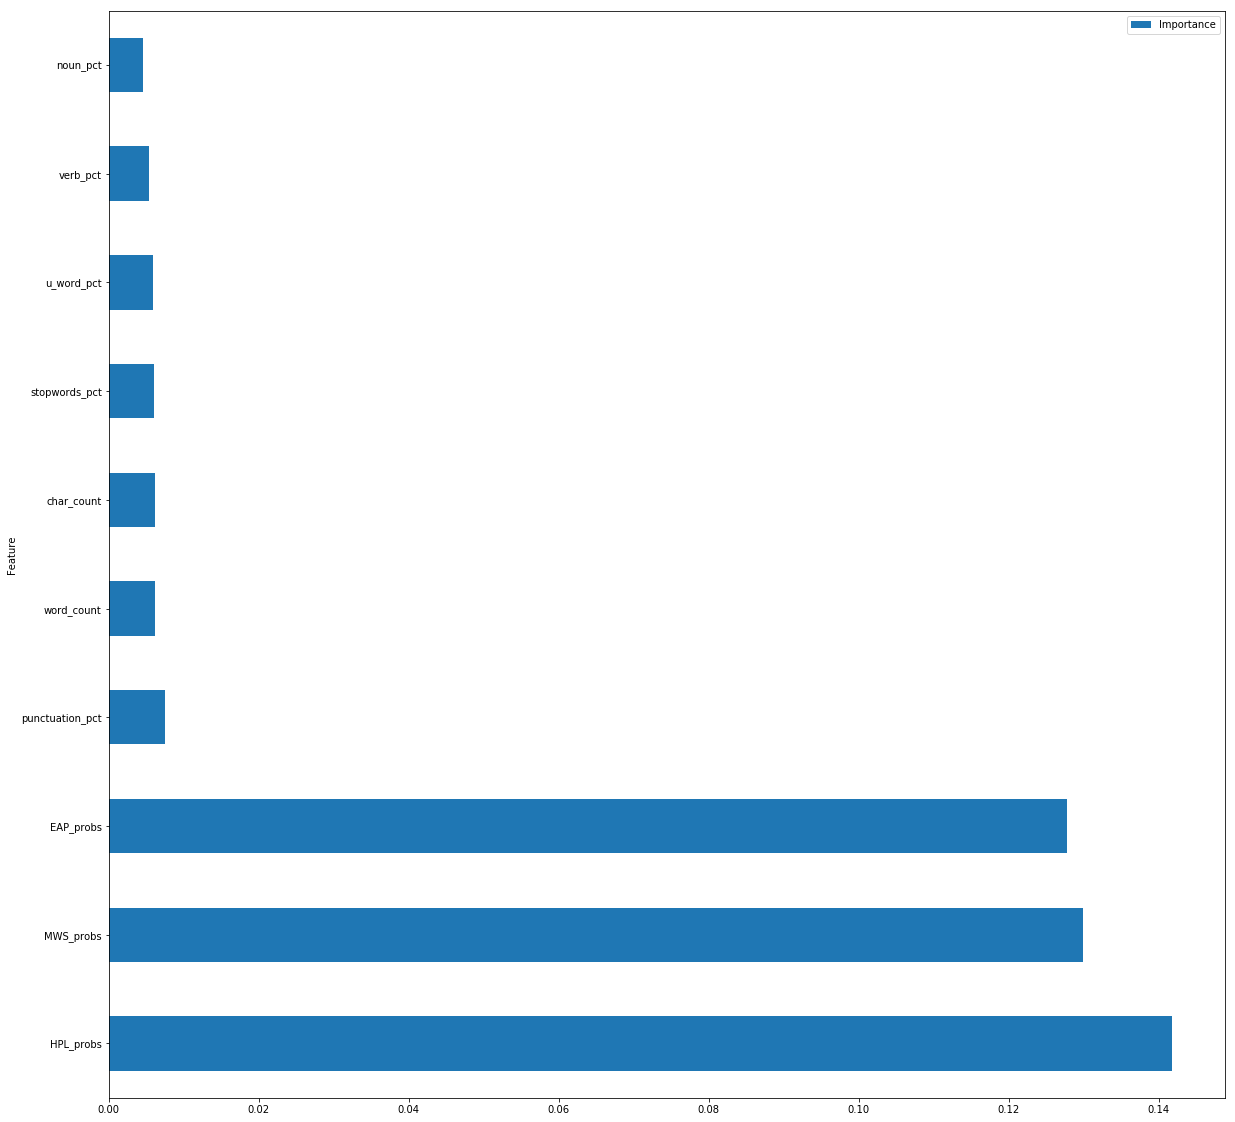

In [57]:
features[:10].plot(kind='barh', figsize=(20,20))

Let's now transform our training set and test to be more compact

In [58]:
model = SelectFromModel(clf, prefit=True, threshold=6e-04)

X_train_new = model.transform(X_train)
# X_test_new = model.transform(X_test)

X_train_new.shape #, X_test_new.shape

(19579, 100)

## Hyperparameters tuning

Random Forest come with a variety of parameters that you can tweak to get an optimal model for your prediction task.

To learn more about Random Forest:  https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/

The model is built by scanning all combinations of hyperparameters and selecting the best combination for predictions against a validation dataset

In [ ]:
clf = RandomForestClassifier()

# parameter_grid = {
#     'max_features': ['sqrt'],
#     'max_depth' : [4, 5, 6, 7, 8],
#     'n_estimators': [200, 210, 240, 250],
#     'criterion': ['gini','entropy']
# }

parameter_grid = {
    'max_depth': [4, 5, 6, 7, 8],
    'n_estimators': [200, 210, 240, 250],
    'max_features': ['sqrt', 'auto', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

cross_validation = StratifiedKFold(y_train, n_folds=5)

grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=cross_validation)
grid_search.fit(X_train_new, y_train)

print(f'Best score: {grid_search.best_score_}')
print(f'Best parameters: {grid_search.best_params_}')